In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.ticker as ticker


import Window_Function
import HERA_hack_FG
import pspec
import make_universe

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=11
plt.rcParams['xtick.labelsize']=11



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notes For Adrian

The first thing to note is that the circular and linear binning don't exactly yield the same spectra. This can also be seen after the spectrum plotting when the binned window functions are plotted. 

The plots below have the amplitude of the spectra normalized for shape matching purposes but I can assure you that there still remains a large descrpancy between the amplitudes of the spectra (sadness)



# Toggle Primary Beam and Normalization

In [5]:
# you can use true and false to turn these on or off. 

pbeam = False 
norm = True 

In [6]:
################## TELESCOPE STUFF ##################
dishes = np.array([[0,0],[0,-57.39295490174667],[30,0]])#,[0,60],[2,55]])#,[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_128.dat')
hera_bls = data[:,:-1]

npix_row,npix_col = 60,60

#dishes = np.array([[0,0],[33.33,0],[0,70.71],[33.33, 70.71]])
acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

HERA = HERA_hack_FG.telescope(dishes, latitude=-30, channel_width=0.1, Tsys=300, beam_width=2, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 1, freq = 150, delta_t = 0.01 ,corners = acorner, beam_sigma_cutoff=2.5, sky_shape = (npix_row,npix_col), norm = norm, pbeam = pbeam)

obs.compute_M(None,None)

############# DEFINE FAKE UNIVERSE SPEC #########
Ly = 2000
Lx = 2000

def ps(x):
    mu, sigma = 0.027348316,0.004
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))
#     return np.sin(100*x)

make_uni = make_universe.universe(ps,obs.sky_shape[0],obs.sky_shape[1],Ly,Lx, mean = None) #100 Mpc by 100Mpc





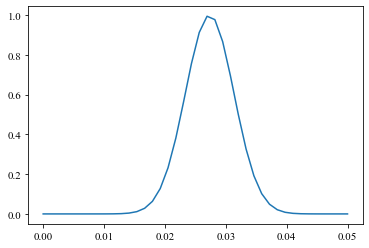

In [4]:
x = np.linspace(0,0.05,40)
plt.plot(x, ps(x))

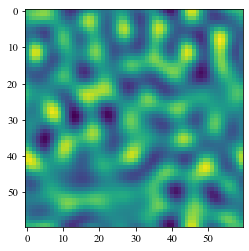

In [5]:
universe, universe_stdev = make_uni.make_2D_universe()


plt.imshow(universe_stdev)

# Computing Ensemble Average P(k) of observed field

In [34]:
nreal = 2000 #number of realizations 
nbins = 40

sum_spec_obs = np.zeros(nbins-1)
sum_spec_real = np.zeros(nbins-1)
sum_spec_total = np.zeros(3600)
sum_k_total = np.zeros(3600)
k_hera = []

cov_matrix = np.zeros((3600,3600))
cov_matrix_stdev = np.zeros((3600,3600))
#size of the box
Lx_hera = cosmo.comoving_distance(8.5).value*obs.delta_phi*obs.sky_shape[0]
Ly_hera = cosmo.comoving_distance(8.5).value*obs.delta_theta*obs.sky_shape[1]

fft_box = np.zeros((60,60))
fft_data = np.zeros((60,60))


for i in range(nreal):
    #make fake universe
    universe, universe_stdev = make_uni.make_2D_universe()
    
    #compute its pspec
    power_spec = pspec.Power_Spectrum(universe.T,2000 ,2000,nbins,False) #100 Mpc by 100Mpc --> have to scale fft I think 
    pk_real = power_spec.compute_2D_pspec()
    sum_spec_real += pk_real[1] #find the average spec 
    cov_matrix += np.real(power_spec.outer_prod)
    
    power_spec_stdev = pspec.Power_Spectrum(universe_stdev.T,2000 ,2000,nbins,False) #100 Mpc by 100Mpc --> have to scale fft I think 
    pk_real_stdev = power_spec_stdev.compute_2D_pspec()
    cov_matrix_stdev += np.real(power_spec_stdev.outer_prod)
    
    if i == 0:
        fft_box = make_uni.fft_box
        fft_data = power_spec.fft_data
    else:
        pass


    #observe the fake universe
    stacked_sky = np.hstack(universe.T)
    sky = np.real(obs.convolve_map(stacked_sky,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col))
    
    #calculate output spec
    power_spec_telescope = pspec.Power_Spectrum(square_sky,Ly_hera ,Lx_hera,nbins = nbins,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
    pk_telescope = power_spec_telescope.compute_2D_pspec()
    sum_spec_obs += pk_telescope[1] #average
    sum_spec_total += np.reshape(np.real(power_spec_telescope.ps_data)/(power_spec_telescope.Ly*power_spec_telescope.Lx), (3600,))
    sum_k_total += power_spec_telescope.k
    
    
    if i == 0:#make sure to save the ks!
        k_hera = pk_telescope[0]
    else:
        pass

averaged_obs = sum_spec_obs/nreal
averaged_real = sum_spec_real/nreal
cov_matrix = cov_matrix/nreal
cov_matrix_stdev = cov_matrix_stdev/nreal
########### THIS IS THE INPUT "TRUE" ENSEMBLE AVERAGED SPECTRUM######
window_input_spec = np.array([pk_real[0],averaged_real])

In [7]:
universe = make_uni.make_2D_universe()

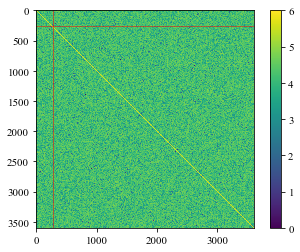

In [102]:
plt.imshow(np.log10(np.abs(cov_matrix)), vmin = 0, vmax = 6,interpolation = 'none')
plt.axhline(y = 252, c = 'r',lw = 0.5)
plt.axvline(x = 283, c = 'r',lw = 0.5)
plt.colorbar()

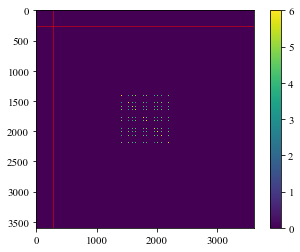

In [103]:
plt.imshow(np.log10(np.abs(cov_matrix_stdev)), vmin = 0, vmax = 6, interpolation = 'none')
plt.axhline(y = 252, c = 'r',lw = 0.5)
plt.axvline(x = 283, c = 'r',lw = 0.5)
plt.colorbar()

In [12]:
print(cov_matrix[252,252],cov_matrix_stdev[252,252])

1798442.5078225627 1798442.5078225627


In [ ]:
window.FFT()
non_diag = np.einsum('ik,mj,km->ij', window.M_tilde,np.conj(window.M_tilde).T,cov_matrix_stdev)

diag = np.einsum('ik,mj,km->ij', window.M_tilde,np.conj(window.M_tilde).T,np.diag(np.diag(cov_matrix_stdev)))

data = [non_diag,diag, np.abs(non_diag-diag)]

x,y = np.linspace(0,3600,3600),np.linspace(0,3600,3600)

fig, axs = plt.subplots(1,3, figsize = (15,4),squeeze=False)

axs[0][0].set_title('$\hat{\hat{M}}\hat{\hat{M}}^t$cov_matrix_stdev')
axs[0][1].set_title('$\hat{\hat{M}}\hat{\hat{M}}^t$np.diag(cov_matrix_stdev)')
axs[0][2].set_title('residual')
for row in range(3):
    ax = axs[0][row]
    pcm = ax.pcolormesh(x,y,data[row])
    fig.colorbar(pcm, ax=ax)




<ipython-input-137-9510a6a0290b>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(x,y,data_sando[row])


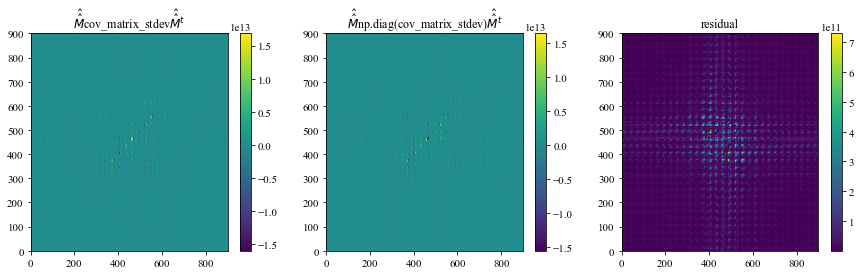

In [137]:
non_diag_sando = np.real(np.dot(window.M_tilde,cov_matrix_stdev).dot(np.conj(window.M_tilde).T))
diag_sando = np.real(np.dot(window.M_tilde,np.diag(np.diag(cov_matrix_stdev))).dot(np.conj(window.M_tilde).T))

data_sando = [non_diag_sando, diag_sando, np.abs(non_diag_sando - diag_sando)]

fig, axs = plt.subplots(1,3, figsize = (15,4),squeeze=False)

axs[0][0].set_title('$\hat{\hat{M}}$cov_matrix_stdev$\hat{\hat{M}}^t$')
axs[0][1].set_title('$\hat{\hat{M}}$np.diag(cov_matrix_stdev)$\hat{\hat{M}}^t$')
axs[0][2].set_title('residual')
for row in range(3):
    ax = axs[0][row]
    pcm = ax.pcolormesh(x,y,data_sando[row])
    fig.colorbar(pcm, ax=ax)




Text(0.5, 1.0, 'diagonalized sandwich - diagnoalized with W')

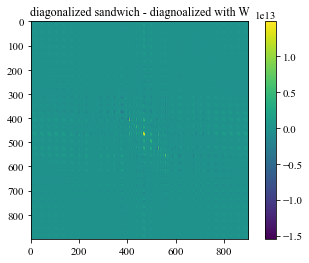

In [146]:
plt.imshow(diag_sando - diag,interpolation = 'none')
plt.colorbar()
plt.title('diagonalized sandwich - diagnoalized with W')

Text(0.5, 1.0, 'diagonalized sandwich - diagnoalized with W')

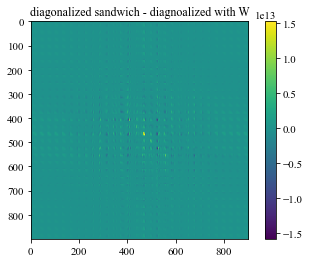

In [145]:
plt.imshow(non_diag_sando - non_diag, interpolation = 'none')
plt.colorbar()
plt.title('diagonalized sandwich - diagnoalized with W')

<ipython-input-197-60838d7282bc>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov_matrix - cov_matrix_stdev)))


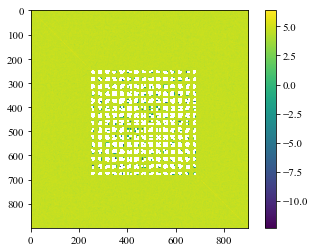

In [197]:
plt.imshow(np.log10(np.abs(cov_matrix - cov_matrix_stdev)))
plt.colorbar()


In [ ]:
plt.imshow(np.real(fft_box))

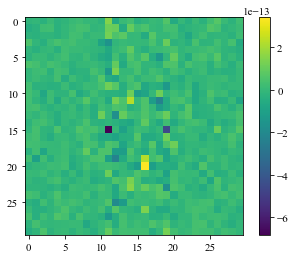

In [80]:
plt.imshow(np.real(fft_box.T)-np.real(fft_data) )
plt.colorbar() 

In [86]:
print(cov_matrix)

[[1061715.73657484  -33940.57005956   42523.98405619 ... -138164.28213126
  -170051.82577856   15470.61861249]
 [ -33940.57005956 1829113.26092863  -65431.2323853  ...  106469.69129102
    55539.07380737  -78921.51191388]
 [  42523.98405619  -65431.2323853  2019966.97838018 ...   21880.60537337
    -9256.97631116  136455.2216863 ]
 ...
 [-138164.28213126  106469.69129102   21880.60537337 ... 1927160.85722707
    26059.3319597  -129257.52917073]
 [-170051.82577856   55539.07380737   -9256.97631116 ...   26059.3319597
  2251021.97187136  -32047.81120539]
 [  15470.61861249  -78921.51191388  136455.2216863  ... -129257.52917073
   -32047.81120539 2165537.09305858]]


In [73]:
window.FFT()
plt.imshow(window.cov)
plt.colorbar()

AttributeError: 'Window_Function' object has no attribute 'cov'

In [7]:
nbins = 40
window = Window_Function.Window_Function(obs.Mmat,obs.sky_shape[0],obs.sky_shape[1],obs.delta_phi,obs.delta_theta,150,nbins,norm = False,linear_bin = True)



In [99]:
window.evaluate_pspec_theory(ps)

39


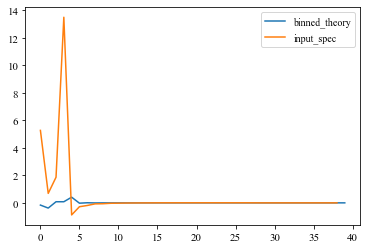

In [100]:
print(len(window_input_spec[1]))

p_est = np.dot(window.window_binned,window.pspec_binned)
p_est_arr = np.dot(window.window_binned[1:,1:],window_input_spec[1])
plt.plot(p_est,label = 'binned_theory')
plt.plot(p_est_arr,label = 'input_spec')
plt.legend()

# Compute and Plot Window Function w/ Linear Binning Hack

/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/Window_Function.py:332: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Window_Function_Debug/Window_Function.py:332: RuntimeWarning: invalid value encountered in true_divide
  
/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


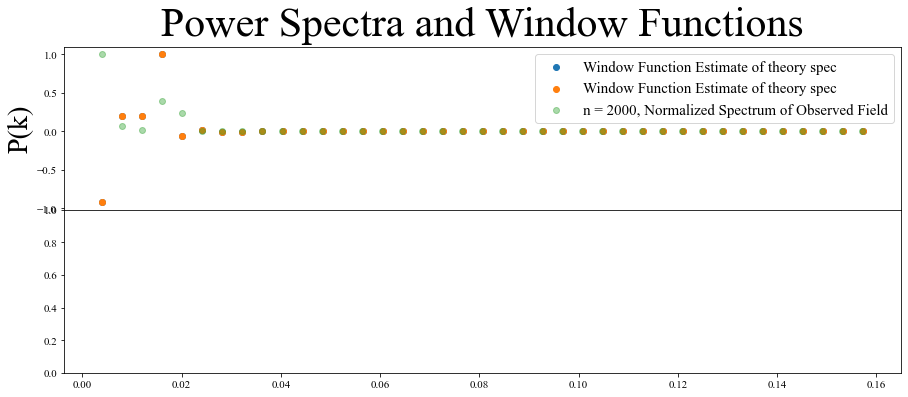

In [101]:
################### WINDOW STUFF ###############

window = Window_Function.Window_Function(obs.Mmat,obs.sky_shape[0],obs.sky_shape[1],obs.delta_phi,obs.delta_theta,150,nbins,norm = False,linear_bin = True)

kk_universe,edges_universe ,pk_universe = window.compute_pspec_estimate(ps)

averaged_total = sum_spec_total/nreal
averaged_k = sum_k_total/nreal

################ PLOTTING ############################
fig, ax = plt.subplots(2, 1, figsize = (15,6),sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})
ax[0].scatter(edges_universe[1:40],pk_universe[1:]/max(pk_universe[1:]), label = 'Window Function Estimate of theory spec')
ax[0].scatter(edges_universe[1:40],p_est[1:]/max(p_est[1:]), label = 'Window Function Estimate of theory spec')
ax[0].scatter(k_hera,averaged_obs/max(averaged_obs), alpha = 0.4 ,label = 'n = %s, Normalized Spectrum of Observed Field'%nreal)
# ax[0].scatter(window.k_sorted,np.dot(window.window_sorted,ps(window.k_sorted))/max(np.dot(window.window_sorted,ps(window.k_sorted))), label = 'k-vector')
# ax[0].scatter(window.k_sorted, ps(window.k_sorted), label = 'true spec')
# ax[0].scatter(averaged_k,averaged_total/max(averaged_total), label = 'unbinned spec of map %s'%nreal)
ax[0].set_ylabel('P(k)',fontsize = 28)
ax[0].set_title('Power Spectra and Window Functions',fontsize = 42 , y = 1.03)
# ax[0].axvline(x=0.023, label = "baseline k")
ax[0].legend(fontsize = 15)

In [102]:
max(pk_universe),max(averaged_obs)

(0.41189201774842665, 84663.75636350733)

In [40]:
print(len(k_hera),len(pk_universe))

39 40


In [93]:
averaged_total = sum_spec_total/nreal
averaged_k = sum_k_total/nreal

################ PLOTTING ############################
fig, ax = plt.subplots(2, 1, figsize = (15,6),sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})

# ax[0].scatter(edges_universe[:40],pk_universe/max(pk_universe), label = 'Window Function Estimate of theory spec')
# ax[0].scatter(k_hera,averaged_obs/max(averaged_obs), alpha = 0.4 ,label = 'n = %s, Normalized Spectrum of Observed Field'%nreal)
ax[0].scatter(window.k_sorted,np.dot(window.window_sorted,ps(window.k_sorted))/max(np.dot(window.window_sorted,ps(window.k_sorted))), label = 'k-vector')
# ax[0].scatter(window.k_sorted, ps(window.k_sorted), label = 'true spec')
ax[0].scatter(averaged_k,averaged_total/max(averaged_total), label = 'unbinned spec of map %s'%nreal)
ax[0].set_ylabel('P(k)',fontsize = 28)
ax[0].set_title('Power Spectra and Window Functions',fontsize = 42 , y = 1.03)
# ax[0].axvline(x=0.023, label = "baseline k")
ax[0].legend(fontsize = 15)

NameError: name 'sum_spec_total' is not defined

In [94]:
averaged_total = sum_spec_total/nreal
averaged_k = sum_k_total/nreal

################ PLOTTING ############################
fig, ax = plt.subplots(2, 1, figsize = (15,6),sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})

# ax[0].scatter(edges_universe[:40],pk_universe/max(pk_universe), label = 'Window Function Estimate of theory spec')
# ax[0].scatter(k_hera,averaged_obs/max(averaged_obs), alpha = 0.4 ,label = 'n = %s, Normalized Spectrum of Observed Field'%nreal)
ax[0].scatter(window.k_sorted,np.dot(window.window_sorted,ps(window.k_sorted))/max(np.dot(window.window_sorted,ps(window.k_sorted))), label = 'k-vector')
# ax[0].scatter(window.k_sorted, ps(window.k_sorted), label = 'true spec')
ax[0].scatter(averaged_k,averaged_total/max(averaged_total), label = 'unbinned spec of map %s'%nreal)
ax[0].set_ylabel('P(k)',fontsize = 28)
ax[0].set_title('Power Spectra and Window Functions',fontsize = 42 , y = 1.03)
# ax[0].axvline(x=0.023, label = "baseline k")
ax[0].legend(fontsize = 15)

NameError: name 'sum_spec_total' is not defined

In [95]:
print(np.sort(averaged_k))


NameError: name 'averaged_k' is not defined

In [28]:
print(window.k_sorted)

[0.         0.00373871 0.00373871 0.00373871 0.00373871 0.00528734
 0.00528734 0.00528734 0.00528734 0.00747743 0.00747743 0.00747743
 0.00747743 0.00836002 0.00836002 0.00836002 0.00836002 0.00836002
 0.00836002 0.00836002 0.00836002 0.01057468 0.01057468 0.01057468
 0.01057468 0.01121614 0.01121614 0.01121614 0.01121614 0.01182285
 0.01182285 0.01182285 0.01182285 0.01182285 0.01182285 0.01182285
 0.01182285 0.01348013 0.01348013 0.01348013 0.01348013 0.01348013
 0.01348013 0.01348013 0.01348013 0.01495486 0.01495486 0.01495486
 0.01495486 0.01541512 0.01541512 0.01541512 0.01541512 0.01541512
 0.01541512 0.01541512 0.01541512 0.01586202 0.01586202 0.01586202
 0.01586202 0.01672004 0.01672004 0.01672004 0.01672004 0.01672004
 0.01672004 0.01672004 0.01672004 0.01869357 0.01869357 0.01869357
 0.01869357 0.01869357 0.01869357 0.01869357 0.01869357 0.01869357
 0.01869357 0.01869357 0.01869357 0.01906378 0.01906378 0.01906378
 0.01906378 0.01906378 0.01906378 0.01906378 0.01906378 0.0201

# Compute and Plot Window Function w/ Circular Binning 

areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail
areas fail


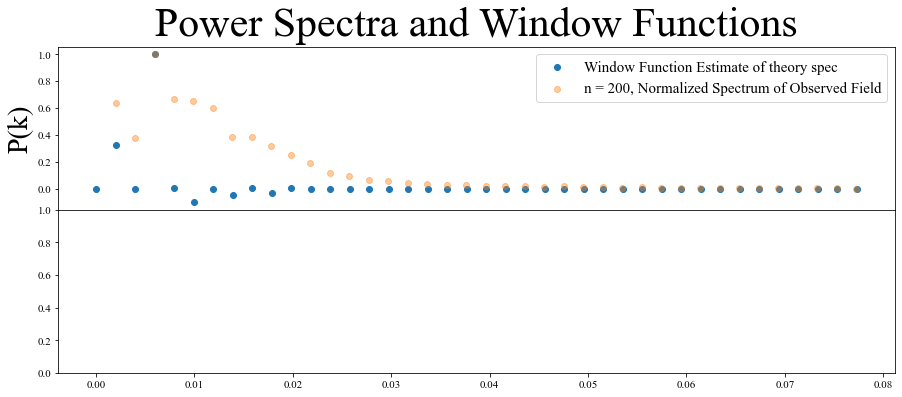

In [246]:
################### WINDOW STUFF ###############

window = Window_Function.Window_Function(obs.Mmat,obs.sky_shape[0],obs.sky_shape[1],obs.delta_phi,obs.delta_theta,150,40,norm = False,linear_bin = False)

kk_universe,edges_universe ,pk_universe = window.compute_pspec_estimate(window_input_spec)


################ PLOTTING ############################
fig, ax = plt.subplots(2, 1, figsize = (15,6),sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})

ax[0].scatter(edges_universe[:40],pk_universe/max(pk_universe), label = 'Window Function Estimate of theory spec')
ax[0].scatter(k_hera,averaged_obs/max(averaged_obs), alpha = 0.4 ,label = 'n = %s, Normalized Spectrum of Observed Field'%nreal)


ax[0].set_ylabel('P(k)',fontsize = 28)
ax[0].set_title('Power Spectra and Window Functions',fontsize = 42 , y = 1.03)
# ax[0].axvline(x=0.023, label = "baseline k")
ax[0].legend(fontsize = 15)

# Binned Window Functions 

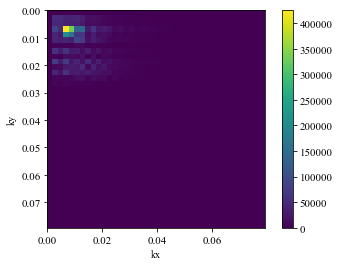

In [41]:
## Here we plot the binned window function by binning in shells of equal k magnitude

window.circular_bin()
circ_binned = window.W_collapse

plt.imshow(circ_binned,extent=[0,max(window.bin_edges),max(window.bin_edges),0])
plt.xlabel('kx')
plt.ylabel('ky')
plt.colorbar()

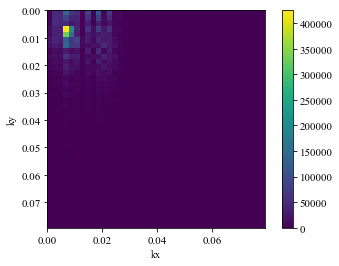

In [42]:
## Here we bin with the linear binning hack

window.bin_window() 
linear_binned = window.W_collapse

plt.imshow(linear_binned,extent=[0,max(window.bin_edges),max(window.bin_edges),0])
plt.xlabel('kx')
plt.ylabel('ky')
plt.colorbar()

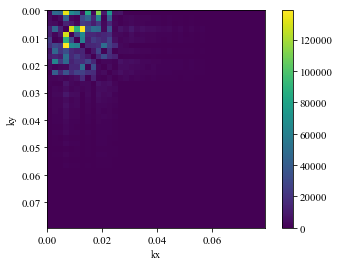

In [43]:
## residual of different binnings because there are clearly significant differences...### 

plt.imshow(np.abs(circ_binned - linear_binned),extent=[0,max(window.bin_edges),max(window.bin_edges),0])
plt.xlabel('kx')
plt.ylabel('ky')
plt.colorbar()

In [46]:
# if you'd like to see the full array of kx and ky unbinned they are:

print(window.k_row) #ky
print(window.k_col) #kx
print(window.k_sorted)#kmag, sorted

#The binned version of kmag is just denoted by the bin edges:
print(window.bin_edges)

[-0.05608072 -0.05234201 -0.04860329 -0.04486458 -0.04112586 -0.03738715
 -0.03364843 -0.02990972 -0.026171   -0.02243229 -0.01869357 -0.01495486
 -0.01121614 -0.00747743 -0.00373871  0.          0.00373871  0.00747743
  0.01121614  0.01495486  0.01869357  0.02243229  0.026171    0.02990972
  0.03364843  0.03738715  0.04112586  0.04486458  0.04860329  0.05234201]
[-0.05608072 -0.05234201 -0.04860329 -0.04486458 -0.04112586 -0.03738715
 -0.03364843 -0.02990972 -0.026171   -0.02243229 -0.01869357 -0.01495486
 -0.01121614 -0.00747743 -0.00373871  0.          0.00373871  0.00747743
  0.01121614  0.01495486  0.01869357  0.02243229  0.026171    0.02990972
  0.03364843  0.03738715  0.04112586  0.04486458  0.04860329  0.05234201]
[0.         0.00373871 0.00373871 0.00373871 0.00373871 0.00528734
 0.00528734 0.00528734 0.00528734 0.00747743 0.00747743 0.00747743
 0.00747743 0.00836002 0.00836002 0.00836002 0.00836002 0.00836002
 0.00836002 0.00836002 0.00836002 0.01057468 0.01057468 0.01057468


In [10]:
window.FFT()
universe, universe_stdev = make_uni.make_2D_universe()

    
stacked_sky = np.hstack(universe_stdev.T)
sky = np.real(obs.convolve_map(stacked_sky,None,None))
square_sky = np.reshape(sky,(npix_row,npix_col)) # do not include .T here for window functioning! (I think)


<ipython-input-11-c34d50aa71f1>:7: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(C_ij_obs), interpolation = 'none')


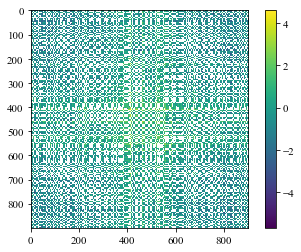

In [11]:
fft_sky = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(square_sky))), (900,))

C_ij_obs = np.real(np.outer(fft_sky,(np.conj(fft_sky).T)))



plt.imshow(np.log10(C_ij_obs), interpolation = 'none')
plt.colorbar()

<ipython-input-53-297f1e67c437>:15: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(MCM), interpolation = 'none')


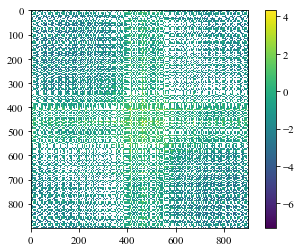

In [53]:
fft_uni = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(universe_stdev))), (900,))

ck = np.outer(fft_uni,np.conj(fft_uni).T)

ck = np.diag(np.diag(ck))
 
cov_mx = window.M_tilde.dot(np.conj(window.M_tilde).T).dot(ck)

Mx = np.dot(window.M_tilde,fft_uni)
Mx_t = np.conj(np.dot(window.M_tilde,fft_uni))

MCM = np.real(np.outer(Mx,Mx_t))


plt.imshow(np.log10(MCM), interpolation = 'none')
plt.colorbar()


<ipython-input-23-1b758fc4e42f>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.real(cov_mx)),interpolation = 'none')
<ipython-input-23-1b758fc4e42f>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.real(cov_mx)),interpolation = 'none')


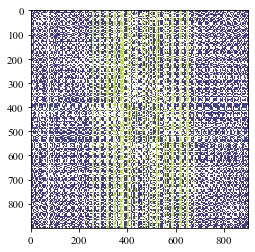

In [23]:
plt.imshow(np.log10(np.real(cov_mx)),interpolation = 'none')

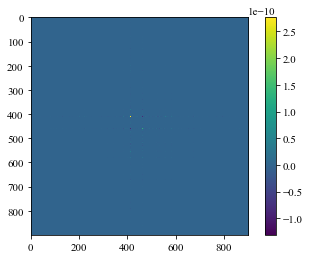

In [261]:
plt.imshow(MCM-C_ij_obs, interpolation = 'none')
plt.colorbar()

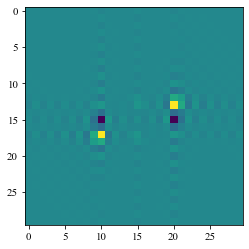

In [262]:
plt.imshow(np.real(np.reshape(fft_sky, (30,30))))

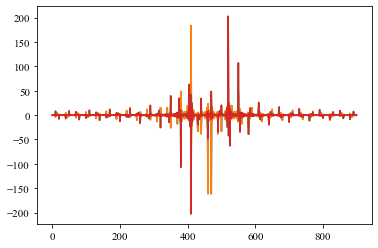

In [263]:
plt.plot(np.real(fft_sky), label = 'x_obs real ')
plt.plot(np.real(Mx), label = 'M_ss x_true real ')
plt.plot(np.imag(fft_sky), label = 'x_obs imag ')
plt.plot(np.imag(Mx),  label = 'M_ss x_true imag ')

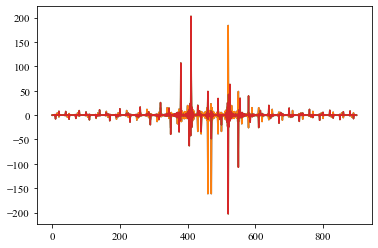

In [264]:
plt.plot(np.real(np.conj(fft_sky).T), label = 'x_obs real ')
plt.plot(np.real(Mx_t), label = 'M_ss x_true real ')
plt.plot(np.imag(np.conj(fft_sky).T), label = 'x_obs imag ')
plt.plot(np.imag(Mx_t),  label = 'M_ss x_true imag ')

In [103]:
nreals = 1000

ave_cov_obs = np.zeros((3600,3600))
ck_ave = np.zeros((3600,3600), dtype = complex)

for i in range(nreals): 
    
    universe, universe_stdev = make_uni.make_2D_universe()

    stacked_sky = np.hstack(universe_stdev.T)
    sky = np.real(obs.convolve_map(stacked_sky,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col)) # do not include .T here for window functioning! (I think)

    fft_sky = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(square_sky))), (3600,))
    C_ij_obs = np.real(np.outer(fft_sky,(np.conj(fft_sky).T)))
    ave_cov_obs += C_ij_obs 
    
    fft_uni = np.reshape(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(universe_stdev))), (3600,))
    ck = np.outer(fft_uni,np.conj(fft_uni).T)
    ck_ave += ck

ave_cov_obs /= nreals
ck_ave = np.diag(np.diag(ck_ave))
ck_ave /=nreals

In [104]:
MM_cov = np.einsum('ik,kj,k->ij', window.M_tilde,np.conj(window.M_tilde).T,np.diag(ck_ave))


<ipython-input-105-5937ff093407>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(ave_cov_obs), interpolation = 'none')


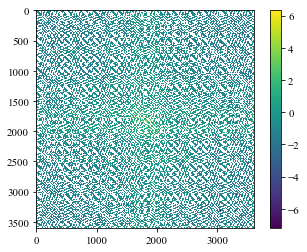

In [105]:
plt.imshow(np.log10(ave_cov_obs), interpolation = 'none')
plt.colorbar()

<ipython-input-106-4a2a1547aafb>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.real(MM_cov)), interpolation = 'none')


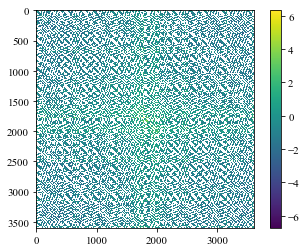

In [106]:
plt.imshow(np.log10(np.real(MM_cov)), interpolation = 'none')
plt.colorbar()

In [107]:
MM_cov_diag = (window.M_tilde*np.conj(window.M_tilde)).dot(np.diag(ck_ave))


<ipython-input-108-3c73f4ef761c>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.real(np.diag(MM_cov_diag))), interpolation = 'none')


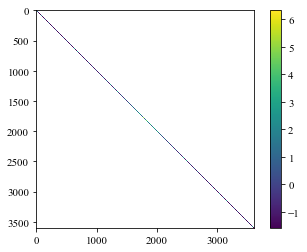

In [108]:
plt.imshow(np.log10(np.real(np.diag(MM_cov_diag))), interpolation = 'none')
plt.colorbar()


<ipython-input-109-44b009134b64>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.diag(np.diag(ave_cov_obs))), interpolation = 'none')


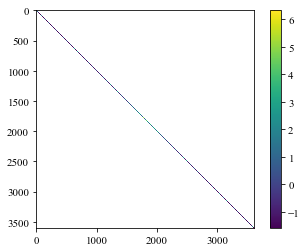

In [109]:
plt.imshow(np.log10(np.diag(np.diag(ave_cov_obs))), interpolation = 'none')
plt.colorbar()

/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


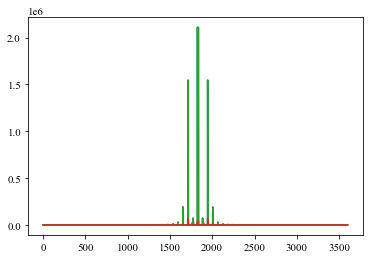

In [163]:
theory_p = np.dot((window.M_tilde*np.conj(window.M_tilde)),ps(window.k))
plt.plot(np.diag(ave_cov_obs)) #<Cii_obs>
plt.plot(np.dot(window.window_sorted,ps(window.k_sorted))) 
plt.plot(MM_cov_diag) # Mconj(M)<ck_true>
plt.plot(theory_p)

#this is a little weird because the ave_cov_obs and MM_cov_diag haven't been sorted...

In [147]:
#take ave_cov_obs: sort, bin, and plot

indices = np.argsort(window.k) #find the indices that sort self.
ave_cov_obs_sorted = np.take(np.diag(ave_cov_obs),indices)#axis 1 sorts the columns into the right order
ave_cov_obs_sorted = np.asarray(ave_cov_obs_sorted) 

MM_cov_diag_sorted = np.take(MM_cov_diag,indices)#axis 1 sorts the columns into the right order
MM_cov_diag_sorted = np.asarray(MM_cov_diag_sorted)#why is this transpose here??? I think because of reshaping but check
k_sorted = np.sort(window.k)

theory_p_sorted = np.take(theory_p,indices)#axis 1 sorts the columns into the right order
theory_p_sorted = np.asarray(theory_p_sorted)


/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/hannahfronenberg/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


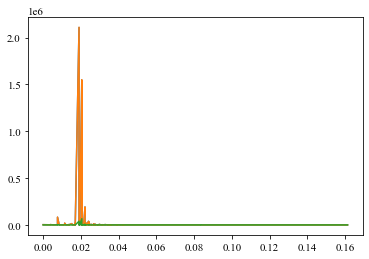

In [148]:
plt.plot(k_sorted,MM_cov_diag_sorted)
plt.plot(k_sorted,ave_cov_obs_sorted)
plt.plot(k_sorted,theory_p_sorted)
#ok... looks about in th right place...

In [149]:
#bin it up 
hist, bin_edges = np.histogram(k_sorted, bins = 40)
pk_obs_binned = np.zeros(40)
min_index = 0
for i in range(len(bin_edges)-1): #pick a bin!
    max_index = np.sum(hist[:i+1])#hist[i] + min_index 
    min_index = np.sum(hist[:i])
    a = np.sum(ave_cov_obs_sorted[min_index:max_index]) #for row j, sum the columns from min to max index of the bin
    c = hist[i] #number of P_k values in that bin 
    pk_obs_binned[i] = a/c #compute average W that bin 
    
pk_window_binned = np.zeros(40)
min_index = 0
for i in range(len(bin_edges)-1): #pick a bin!
    max_index = np.sum(hist[:i+1])#hist[i] + min_index 
    min_index = np.sum(hist[:i])
    a = np.sum(MM_cov_diag_sorted[min_index:max_index]) #for row j, sum the columns from min to max index of the bin
    c = hist[i] #number of P_k values in that bin 
    pk_window_binned[i] = a/c #compute average W that bin
    
pk_theory_binned = np.zeros(40)
min_index = 0
for i in range(len(bin_edges)-1): #pick a bin!
    max_index = np.sum(hist[:i+1])#hist[i] + min_index 
    min_index = np.sum(hist[:i])
    a = np.sum(theory_p_sorted[min_index:max_index]) #for row j, sum the columns from min to max index of the bin
    c = hist[i] #number of P_k values in that bin 
    pk_theory_binned[i] = a/c #compute average W that bin

<ipython-input-149-f12b88876b64>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  pk_window_binned[i] = a/c #compute average W that bin
<ipython-input-149-f12b88876b64>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  pk_theory_binned[i] = a/c #compute average W that bin


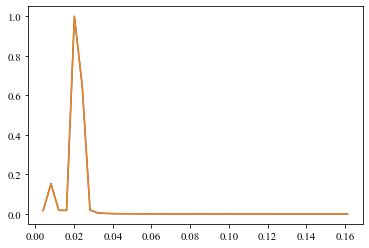

In [157]:
plt.plot(bin_edges[1:],pk_obs_binned/max(pk_obs_binned))
plt.plot(bin_edges[1:],pk_window_binned/max(pk_obs_binned))
# plt.plot(bin_edges[1:],pk_theory_binned/max(pk_theory_binned))

In [12]:
window.compute_sigma()

AttributeError: 'Window_Function' object has no attribute 'compute_sigma'